# Statistics 786 Final
Written by Raafi Rahman in Google Colab

## Summary

####Question

We use a dataset that consists of many different Ford branded cars. The data set used was found on Kaggle posted by user Adhurim Quku. I was unable to find the original source of the data. We will be focusing on the numerical features of the data, columns that tell us what their year, mileage, miles per gallon, and engine size. We will use this data and Bayesian Modeling to determine the answer to this question...

**How much do year, engine size, mileage, and mpg contribute to the rise of price?**

####Data

After loading in the data, we had to do some data cleaning. A column such as 'tax' is not relevant and therefore we dropped it. fuel type is highly correlated to engine size therefore we also dropped that. Transmission type is a categorical variable and we also dropped that. 

There were a few weird things in the data we had to check. For example we had the range for years extending up to 2060. This didn't seem right so we dropped the entries of all vehicles that had a year greater than 2022. Another example was very few cars had an mpg greater than 50. Then there were some in the dataset that had an mpg of over 200. I had to check to make sure there were legit entries. Turns out they were. The Ford Kuga has an mpg of higher than 200, but that is because it is a hybrid.

####Results

First we translate and normalize all data. Then we run Bayesian Linear Regression on all features individually. Lastly we compare the cooeficients to see which has the most impact on the price.

Year: 6850

Engine: 3800

Mileage: -21850

MPG: -31750

The greatest impact was given by the MPG of the car. This a weird category, along with Mileage, since the higher it is, the lower the price is. Mileage has the next biggest impact. After that, the next highest impact comes from Year, how new the car is. Lastly, the next biggest impact comes from engine size.

## Set Up

####Imports

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import scipy.stats as stats
import pymc3 as pm
import theano

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Load and Clean Data

In [2]:
# Load Data
folder = "/content/drive/MyDrive/Colab Notebooks/Modeling and Visualization/Data/ford.csv" # Directiory for data on my specific machine
data = pd.read_csv(folder)

# Clean Data
to_drop = ['fuelType', 'tax', 'transmission']
data.drop(to_drop, inplace=True, axis=1)

data = data.loc[data['year'] <= 2022] # Some entries had year values around 2060. This made no sense

In [3]:
data

,model,year,price,mileage,mpg,engineSize
0,Fiesta,2017,12000,15944,57.7,1.0
1,Focus,2018,14000,9083,57.7,1.0
2,Focus,2017,13000,12456,57.7,1.0
3,Fiesta,2019,17500,10460,40.3,1.5
4,Fiesta,2019,16500,1482,48.7,1.0
...,...,...,...,...,...,...
17961,B-MAX,2017,8999,16700,47.1,1.4
17962,B-MAX,2014,7499,40700,57.7,1.0
17963,Focus,2015,9999,7010,67.3,1.6
17964,KA,2018,8299,5007,57.7,1.2


In [4]:
mpgCheck = data.loc[data['mpg'] >= 90]
mpgCheck # This returns a list of Ford Kugas which are hybrids. The mpg shown is correct, but are definetly outliers.

,model,year,price,mileage,mpg,engineSize
6153,Kuga,2020,31000,10,201.8,2.5
6536,Kuga,2020,31991,2357,201.8,2.5
9220,Kuga,2020,32000,10,201.8,2.5
12862,Kuga,2020,33500,5534,201.8,2.5
13730,Kuga,2020,32995,11,201.8,2.5


In [5]:
modelLs = pd.DataFrame(dict(x=data['model'], y=data['price']))
yearLs = pd.DataFrame(dict(x=data['year'], y=data['price']))
mileageLs = pd.DataFrame(dict(x=data['mileage'], y=data['price']))
mpgLs = pd.DataFrame(dict(x=data['mpg'], y=data['price']))
engineSizeLs = pd.DataFrame(dict(x=data['engineSize'], y=data['price']))

X = data[['year','mileage','mpg', 'engineSize']]
y = data[['price']]

####Features against Price Graphs

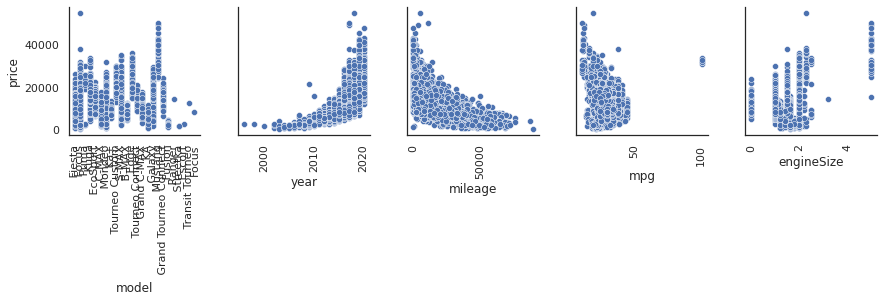

In [6]:
sns.set(style='white', font_scale=1, color_codes=True)

pair = sns.pairplot(data, x_vars=['model', 'year',	'mileage',	'mpg',	'engineSize'], y_vars='price')
for ax in pair.fig.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

## Linear Regression

**Start by introducing our priors**

m ~ N(0,100)

b ~ N(0,100)

σ ~ Exp(1)

**Likelihood**

y | m, b, σ ~ N(mx + b, σ)

**Posterior**

m, b, σ | y ~ ?

**Bayes Theorem**

P(m, b, σ | y) ∝ P(y | m, b, σ) * P(m) * P(b) * P(σ)

#####Year to Price

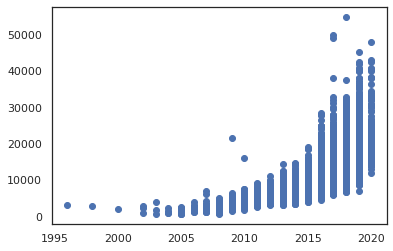

In [7]:
plt.scatter(yearLs['x'], yearLs['y'])

In [8]:
with pm.Model() as lin_model:
  # Priors
  alpha = pm.Normal('alpha', 0, 100)
  beta = pm.Normal('beta', 0, 100)
  sigma = pm.Exponential('sigma', 1/1000)

  mu = alpha + beta*( (yearLs['x'] - yearLs['x'].min()) / (yearLs['x'].max() - yearLs['x'].min()) ) # Translate data towards origin and normalize

  # Likelihood
  y = pm.Normal('y', mu, sigma, observed=yearLs['y'])

  # Posterior
  trace = pm.sample(1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 40 seconds.
The acceptance probability does not match the target. It is 0.901585314176122, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8950728645701516, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c43fe9c50>,
      dtype=object)

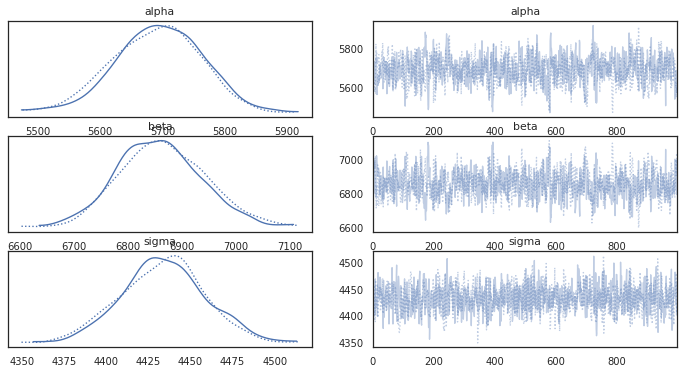

In [9]:
az.plot_trace(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


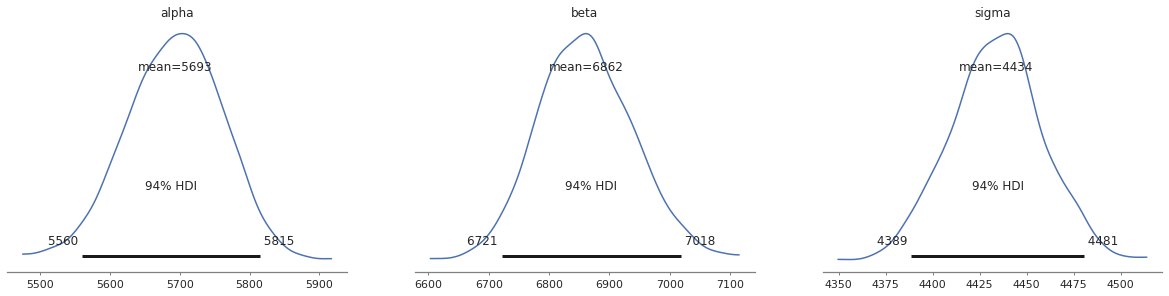

In [10]:
az.plot_posterior(trace);

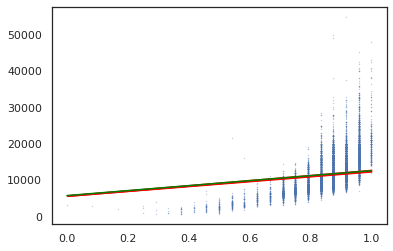

In [11]:
from matplotlib import colors
x=np.linspace(0,1)

y = 6867*x + 5687

plt.scatter((yearLs['x'] - yearLs['x'].min()) / (yearLs['x'].max() - yearLs['x'].min()), yearLs['y'], s=.1, alpha=.5)
plt.plot(x, y, color='green')

#Compute and Plot Credible Intervals
plt.fill_between(x, (6723*x + 5553), (7019*x + 5815), color='red', alpha=1)
plt.fill_between(x, (6723*x + 5815), (7019*x + 5553), color='red', alpha=1)

#####Engine Size to Price

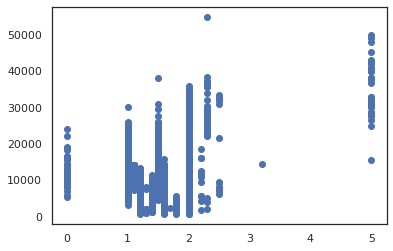

In [12]:
plt.scatter(engineSizeLs['x'], engineSizeLs['y'])

In [13]:
with pm.Model() as lin_model:
  # Priors
  alpha = pm.Normal('alpha', 0, 100)
  beta = pm.Normal('beta', 0, 100)
  sigma = pm.Exponential('sigma', 1/1000)

  mu = alpha + beta*( (engineSizeLs['x'] - engineSizeLs['x'].min()) / (engineSizeLs['x'].max() - engineSizeLs['x'].min()) ) # Translate data towards origin and normalize

  # Likelihood
  y = pm.Normal('y', mu, sigma, observed=engineSizeLs['y'])

  # Posterior
  trace = pm.sample(1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 54 seconds.
The acceptance probability does not match the target. It is 0.8836441185205125, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9152721206010708, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c43d15250>,
      dtype=object)

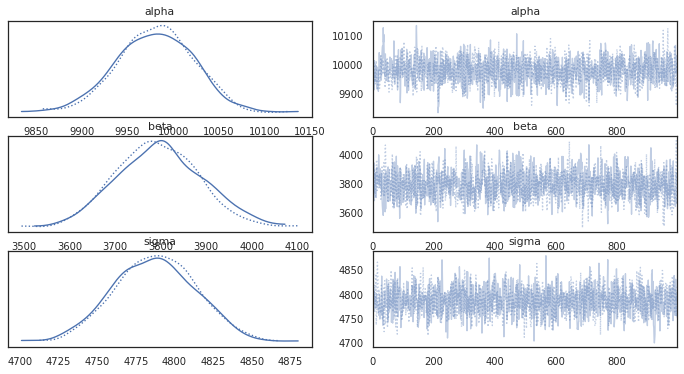

In [14]:
az.plot_trace(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


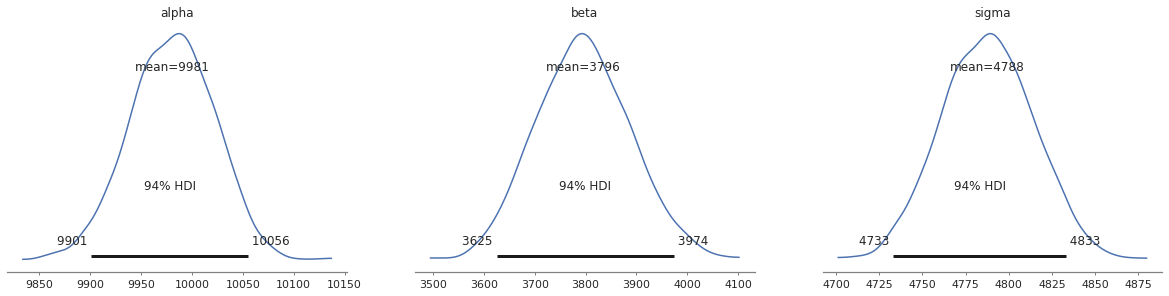

In [15]:
az.plot_posterior(trace);

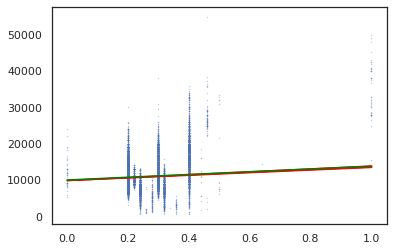

In [16]:
from matplotlib import colors
x=np.linspace(0,1)

y = 3797*x + 9981

plt.scatter((engineSizeLs['x'] - engineSizeLs['x'].min()) / (engineSizeLs['x'].max() - engineSizeLs['x'].min()), engineSizeLs['y'], s=.1, alpha=.5)
plt.plot(x, y, color='green')

#Compute and Plot Credible Intervals
plt.fill_between(x, (3622*x + 9906), (3984*x + 10062), color='red', alpha=1)
plt.fill_between(x, (3622*x + 10062), (3984*x + 9906), color='red', alpha=1)

#####Mileage to Price **Without dealing with outliers**

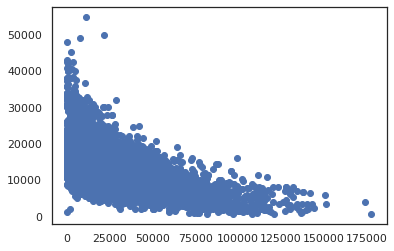

In [17]:
plt.scatter(mileageLs['x'], mileageLs['y'])

In [18]:
with pm.Model() as lin_model:
  # Priors
  alpha = pm.Normal('alpha', 0, 100)
  beta = pm.Normal('beta', 0, 100)
  sigma = pm.Exponential('sigma', 1/1000)

  mu = alpha + beta*( (mileageLs['x'] - mileageLs['x'].min()) / (mileageLs['x'].max() - mileageLs['x'].min()) ) # Translate data towards origin and normalize

  # Likelihood
  y = pm.Normal('y', mu, sigma, observed=mileageLs['y'])

  # Posterior
  trace = pm.sample(1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c480f1e50>,
      dtype=object)

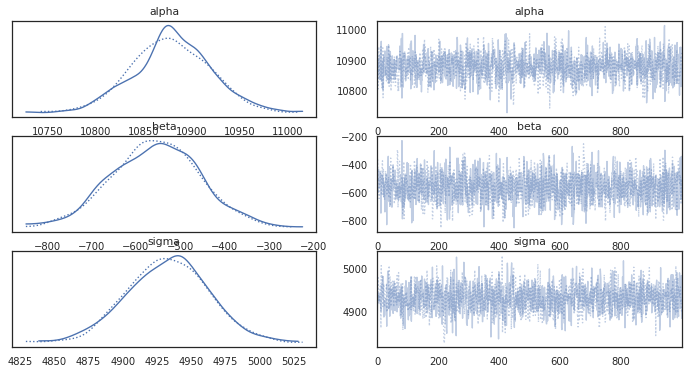

In [19]:
az.plot_trace(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


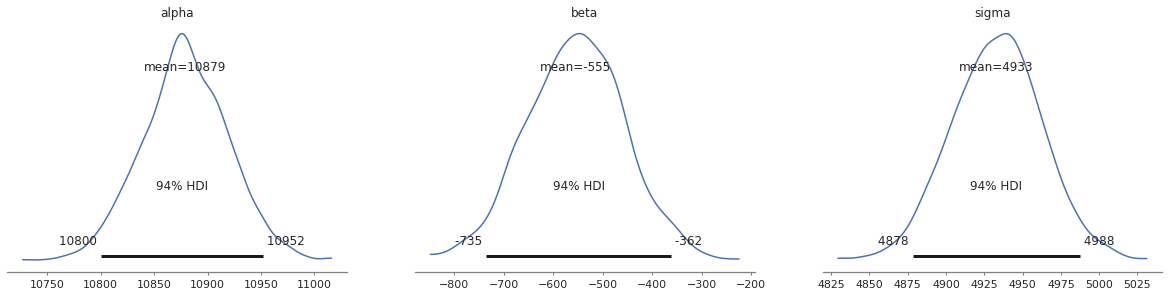

In [20]:
az.plot_posterior(trace);

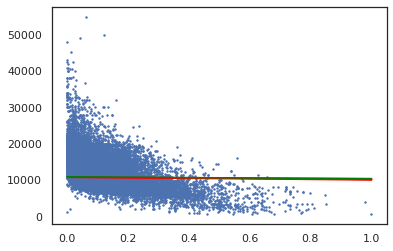

In [21]:
from matplotlib import colors
x=np.linspace(0,1)

y = -555*x + 10878

plt.scatter((mileageLs['x'] - mileageLs['x'].min()) / (mileageLs['x'].max() - mileageLs['x'].min()), mileageLs['y'], s=2)
plt.plot(x, y, color='green')

#Compute and Plot Credible Intervals
plt.fill_between(x, (-748*x + 10801), (-368*x + 10955), color='red', alpha=1)
plt.fill_between(x, (-748*x + 10955), (-368*x + 10801), color='red', alpha=1)

#####Mileage to Price **Dealing with outliers**

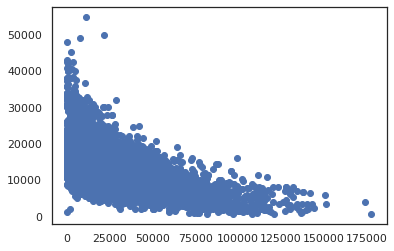

In [22]:
plt.scatter(mileageLs['x'], mileageLs['y'])

In [23]:
with pm.Model() as lin_model:
  # Priors
  alpha = pm.StudentT('alpha', nu=1, mu=0)
  beta = pm.StudentT('beta', nu=1, mu=0)
  sigma = pm.Exponential('sigma', 1/1000)
  nu = pm.Exponential('nu', 1/30)

  mu = alpha + beta*( (mileageLs['x'] - mileageLs['x'].min()) / (mileageLs['x'].max() - mileageLs['x'].min()) ) # Translate data towards origin and normalize

  # Likelihood
  y = pm.StudentT('y', nu=nu, mu=mu, sigma=sigma, observed=mileageLs['y'])

  # Posterior
  trace = pm.sample(1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 52 seconds.
The acceptance probability does not match the target. It is 0.8875329983852398, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c4335d890>,
      dtype=object)

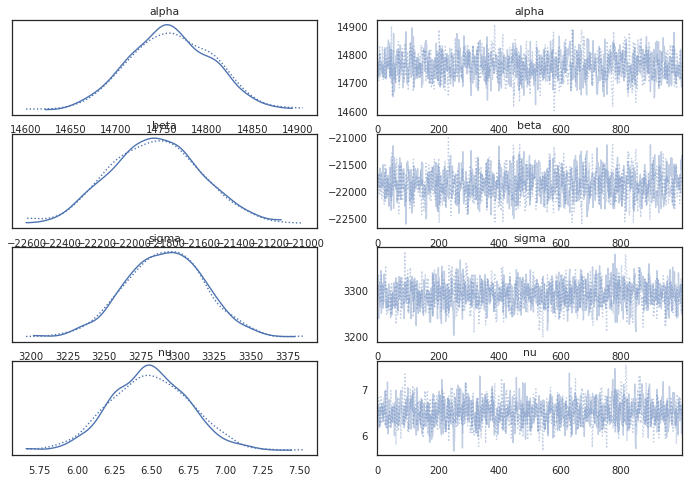

In [24]:
az.plot_trace(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


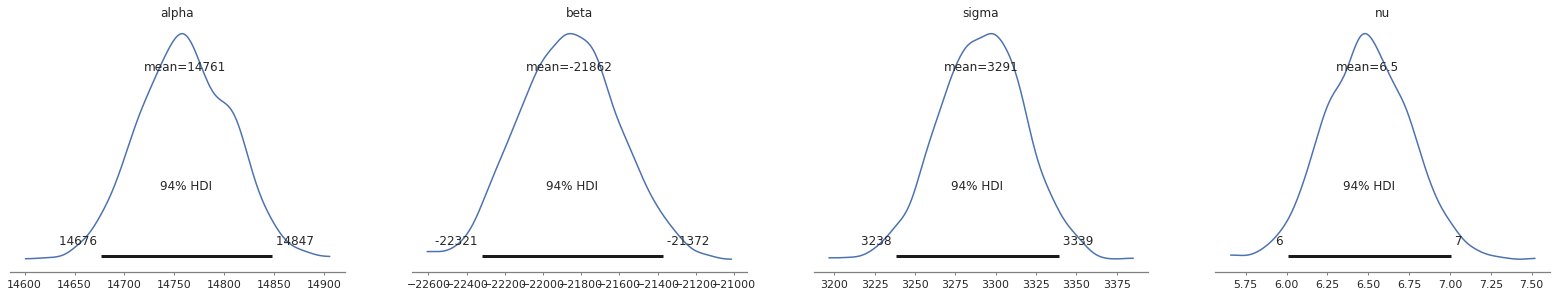

In [25]:
az.plot_posterior(trace);

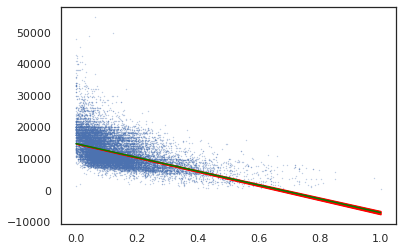

In [26]:
from matplotlib import colors
x=np.linspace(0,1)

y = -21874*x + 14761

plt.scatter((mileageLs['x'] - mileageLs['x'].min()) / (mileageLs['x'].max() - mileageLs['x'].min()), mileageLs['y'], s=.1, alpha=.5)
plt.plot(x, y, color='green')

#Compute and Plot Credible Intervals
plt.fill_between(x, (-22360*x + 14678), (-21403*x + 14852), color='red', alpha=1)
plt.fill_between(x, (-22360*x + 14852), (-21403*x + 14678), color='red', alpha=1)

#####MPG to Price **Without dealing with outliers**

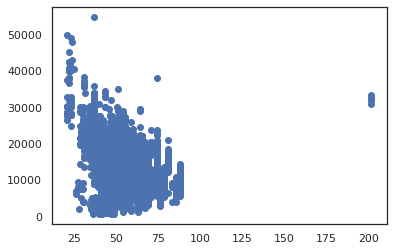

In [27]:
plt.scatter(mpgLs['x'], mpgLs['y'])

In [28]:
with pm.Model() as lin_model:
  # Priors
  alpha = pm.Normal('alpha', 0, 100)
  beta = pm.Normal('beta', 0, 100)
  sigma = pm.Exponential('sigma', 1/1000)

  mu = alpha + beta*( (mpgLs['x'] - mpgLs['x'].min()) / (mpgLs['x'].max() - mpgLs['x'].min()) ) # Translate data towards origin and normalize

  # Likelihood
  y = pm.Normal('y', mu, sigma, observed=mpgLs['y'])

  # Posterior
  trace = pm.sample(1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  del sys.path[0]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8785969303235666, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c42515050>,
      dtype=object)

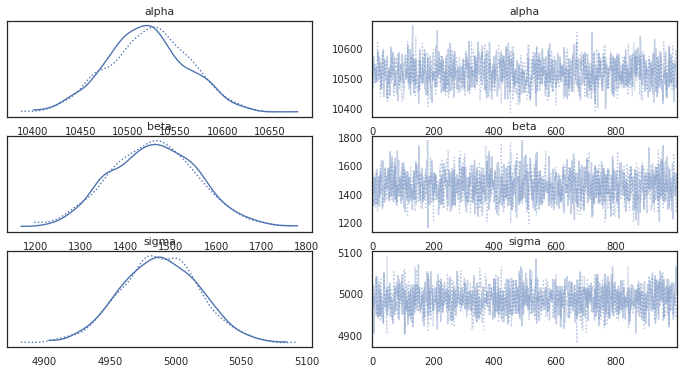

In [29]:
az.plot_trace(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


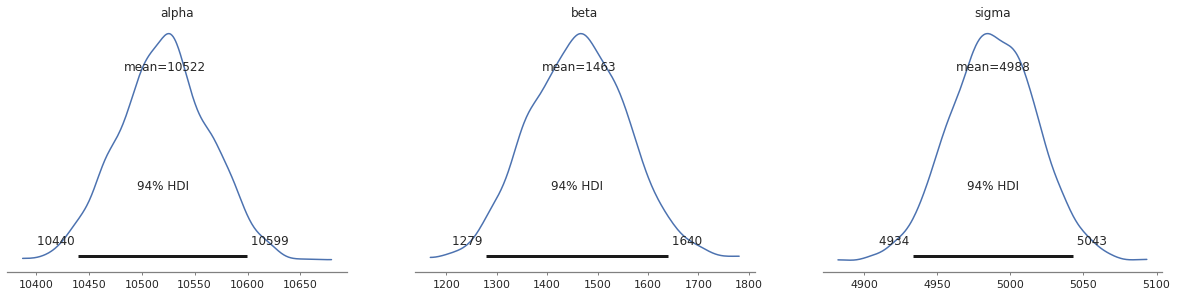

In [30]:
az.plot_posterior(trace);

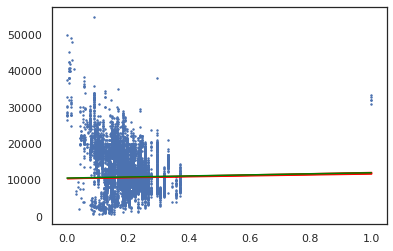

In [31]:
from matplotlib import colors
x=np.linspace(0,1)

y = 1459*x + 10524

plt.scatter((mpgLs['x'] - mpgLs['x'].min()) / (mpgLs['x'].max() - mpgLs['x'].min()), mpgLs['y'], s=2)
plt.plot(x, y, color='green')

#Compute and Plot Credible Intervals
plt.fill_between(x, (10444 + 1269*x), (10604 + 1646*x), color='red', alpha=1)
plt.fill_between(x, (10444 + 1646*x), (10604 + 1269*x), color='red', alpha=1)

#####MPG to Price **Dealing with outliers**

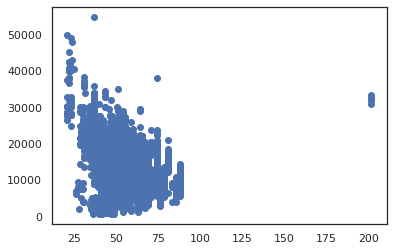

In [32]:
plt.scatter(mpgLs['x'], mpgLs['y'])

In [33]:
with pm.Model() as lin_model:
  # Priors
  alpha = pm.StudentT('alpha', nu=1, mu=0)
  beta = pm.StudentT('beta', nu=1, mu=0)
  sigma = pm.Exponential('sigma', 1/1000)
  nu = pm.Exponential('nu', 1/30)

  mu = alpha + beta*( (mpgLs['x'] - mpgLs['x'].min()) / (mpgLs['x'].max() - mpgLs['x'].min()) ) # Translate data towards origin and normalize

  # Likelihood
  y = pm.StudentT('y', nu=nu, mu=mu, sigma=sigma, observed=mpgLs['y'])

  # Posterior
  trace = pm.sample(1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.
The acceptance probability does not match the target. It is 0.9019991013137351, but should be close to 0.8. Try to increase the number of tuning steps.


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c40d69590>,
      dtype=object)

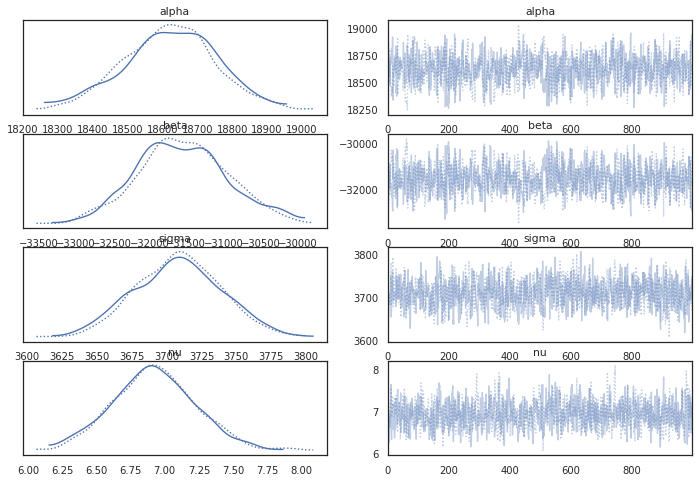

In [34]:
az.plot_trace(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


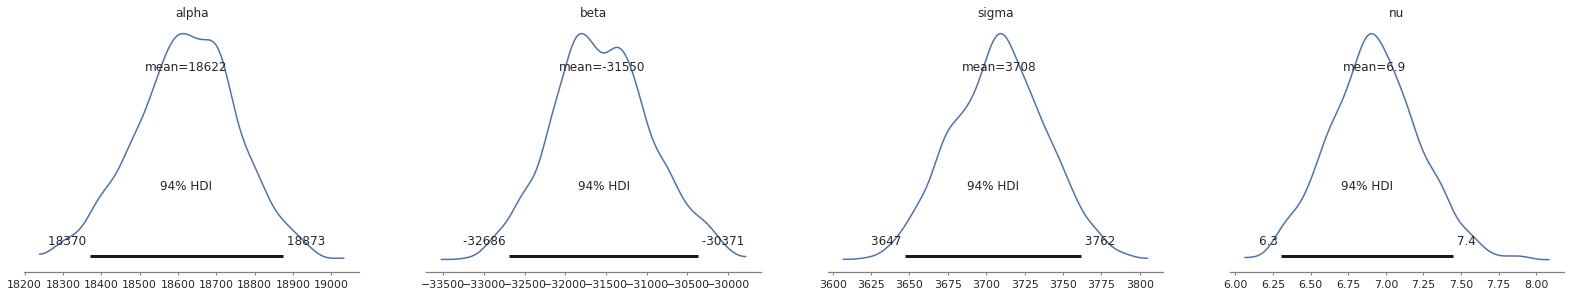

In [35]:
az.plot_posterior(trace);

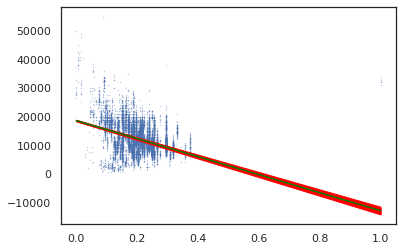

In [36]:
from matplotlib import colors
x=np.linspace(0,1)

y = -31550*x + 18623

plt.scatter((mpgLs['x'] - mpgLs['x'].min()) / (mpgLs['x'].max() - mpgLs['x'].min()), mpgLs['y'], s=.1, alpha=.5)
plt.plot(x, y, color='green')

plt.fill_between(x, (-32640*x + 18393), (-30430*x + 18880), color='red', alpha=1)
plt.fill_between(x, (-32640*x + 18880), (-30430*x + 18393), color='red', alpha=1)

##### Multiple Linear Regression

In [ ]:
with pm.Model() as lin_model:
  # Priors
  alpha = pm.Normal('alpha', 0, 10)
  beta = pm.Normal('beta', 0, 1, shape=4)
  sigma = pm.HalfCauchy('sigma', 5)

  mu = alpha + pm.math.dot(X, beta) # Translate data towards origin and normalize

  # Likelihood
  y = pm.Normal('y', mu, sigma, observed=y)

  # Posterior
  trace = pm.sample(1000)

Keep getting the "Your session crashed after using all available RAM. 